# Forest Cover Type Classification with Deep Learning MLP

## Objective
Build and compare Multi-Layer Perceptron (MLP) models using both PyTorch and TensorFlow to classify forest cover types based on cartographic variables.

## Dataset Information
- **Source**: UCI ML Repository - Forest Cover Type Dataset
- **Target**: Cover_Type (7 different forest cover types)
- **Features**: Cartographic variables (elevation, aspect, slope, etc.)
- **Type**: Multi-class classification problem

## Requirements
1. Implement MLP models using PyTorch and TensorFlow
2. Use comprehensive evaluation metrics (Accuracy, Precision, Recall, F1-Score, AUC, ROC)
3. Provide mathematical explanations for each evaluation metric

In [6]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_score, recall_score, f1_score, roc_auc_score, 
                           roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")

Libraries imported successfully!
PyTorch version: 2.7.1+cpu
TensorFlow version: 2.19.0


## 1. Data Loading and Exploration

In [7]:
# Load the compressed dataset
filename = r"d:\Backup\GitHub\DeepLearning\02. Week 2\Dataset\compressed_data.csv.gz"
df = pd.read_csv(filename, compression='gzip')

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nTarget variable distribution:")
print(df['Cover_Type'].value_counts().sort_index())

print("\nStatistical summary:")
print(df.describe())

Dataset shape: (581012, 55)

First few rows:
   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235         

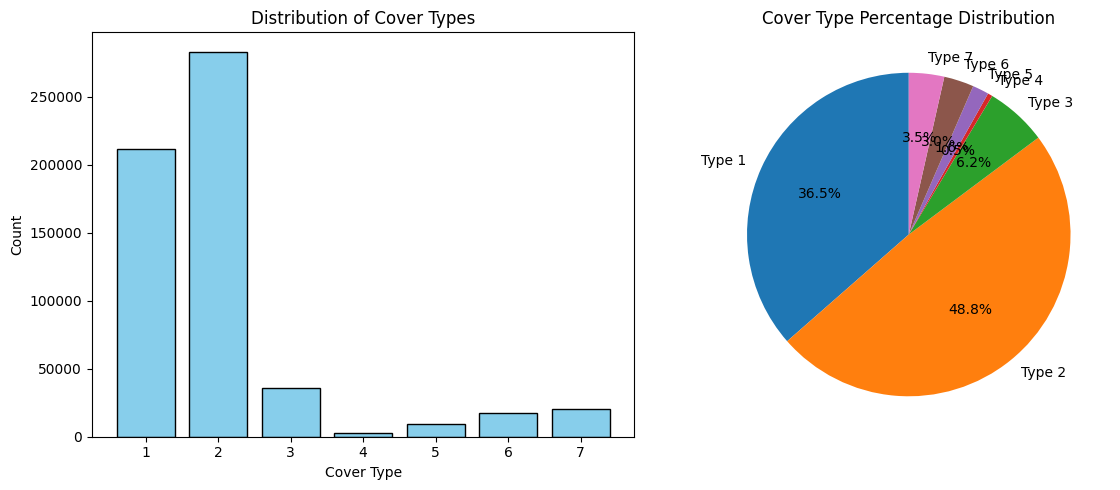

Missing values per column:
Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0
Soil_Type11                           0
Soil_Type12                           0
Soil_Type13                           0
Soil_Type14  

In [8]:
# Visualize the target variable distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cover_counts = df['Cover_Type'].value_counts().sort_index()
plt.bar(cover_counts.index, cover_counts.values, color='skyblue', edgecolor='black')
plt.title('Distribution of Cover Types')
plt.xlabel('Cover Type')
plt.ylabel('Count')
plt.xticks(range(1, 8))

plt.subplot(1, 2, 2)
plt.pie(cover_counts.values, labels=[f'Type {i}' for i in cover_counts.index], 
        autopct='%1.1f%%', startangle=90)
plt.title('Cover Type Percentage Distribution')

plt.tight_layout()
plt.show()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check correlation matrix for numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Cover_Type' in numerical_features:
    numerical_features.remove('Cover_Type')

print(f"\nNumber of features: {len(numerical_features)}")
print("Feature names:", numerical_features[:10], "..." if len(numerical_features) > 10 else "")

## 2. Data Preprocessing

In [9]:
# Separate features and target
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

# Convert target to zero-based indexing (for neural networks)
y_encoded = y - 1  # Convert from 1-7 to 0-6
print("Target classes after encoding:", sorted(y_encoded.unique()))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, 
                                                    random_state=42, stratify=y_encoded)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Feature scaling completed!")
print(f"Training features shape: {X_train_scaled.shape}")
print(f"Test features shape: {X_test_scaled.shape}")

# Convert to tensors for PyTorch
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_train_tensor = torch.LongTensor(y_train.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Convert to categorical for TensorFlow
y_train_categorical = to_categorical(y_train, num_classes=7)
y_test_categorical = to_categorical(y_test, num_classes=7)

print("Data preprocessing completed successfully!")

Features shape: (581012, 54)
Target shape: (581012,)
Target classes after encoding: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Training set size: 464809
Test set size: 116203
Feature scaling completed!
Training features shape: (464809, 54)
Test features shape: (116203, 54)
Data preprocessing completed successfully!


## 3. Mathematical Background of Evaluation Metrics

### 3.1 Accuracy
**Definition**: Proportion of correct predictions over total predictions.

**Formula**: 
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

Where:
- TP = True Positives
- TN = True Negatives  
- FP = False Positives
- FN = False Negatives

### 3.2 Precision
**Definition**: Proportion of positive identifications that were actually correct.

**Formula**: 
$$\text{Precision} = \frac{TP}{TP + FP}$$

**Interpretation**: Of all instances predicted as positive, how many were actually positive?

### 3.3 Recall (Sensitivity)
**Definition**: Proportion of actual positives that were identified correctly.

**Formula**: 
$$\text{Recall} = \frac{TP}{TP + FN}$$

**Interpretation**: Of all actual positive instances, how many were correctly identified?

### 3.4 F1-Score
**Definition**: Harmonic mean of precision and recall.

**Formula**: 
$$\text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{2TP}{2TP + FP + FN}$$

**Interpretation**: Balances precision and recall, useful when you need a single metric.

### 3.5 ROC-AUC (Area Under ROC Curve)
**Definition**: Area under the Receiver Operating Characteristic curve.

**ROC Curve**: Plot of True Positive Rate vs False Positive Rate
- **True Positive Rate (TPR)**: $\frac{TP}{TP + FN}$ (same as Recall)
- **False Positive Rate (FPR)**: $\frac{FP}{FP + TN}$

**AUC Range**: [0, 1], where 1 indicates perfect classification and 0.5 indicates random guessing.

### 3.6 Multi-class Extensions
For multi-class problems, metrics are calculated using:
- **Macro-average**: Calculate metric for each class and take unweighted mean
- **Weighted-average**: Calculate metric for each class and take weighted mean by support
- **Micro-average**: Calculate metric globally by counting total TP, FP, FN

## 4. PyTorch MLP Model Implementation

In [10]:
# Define PyTorch MLP Model
class PyTorchMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, dropout_rate=0.3):
        super(PyTorchMLP, self).__init__()
        
        # Create layers dynamically
        layers = []
        prev_size = input_size
        
        # Hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Model parameters
input_size = X_train_scaled.shape[1]
hidden_sizes = [256, 128, 64]
num_classes = 7
dropout_rate = 0.3
learning_rate = 0.001
batch_size = 256
num_epochs = 100

print(f"Input size: {input_size}")
print(f"Hidden layers: {hidden_sizes}")
print(f"Number of classes: {num_classes}")
print(f"Dropout rate: {dropout_rate}")

# Initialize model
pytorch_model = PyTorchMLP(input_size, hidden_sizes, num_classes, dropout_rate)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pytorch_model.parameters(), lr=learning_rate)

print("PyTorch model initialized successfully!")
print(pytorch_model)

Input size: 54
Hidden layers: [256, 128, 64]
Number of classes: 7
Dropout rate: 0.3
PyTorch model initialized successfully!
PyTorchMLP(
  (network): Sequential(
    (0): Linear(in_features=54, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=64, out_features=7, bias=True)
  )
)


Training PyTorch model...
Epoch [20/100], Loss: 0.3754, Accuracy: 84.52%
Epoch [40/100], Loss: 0.3498, Accuracy: 85.70%
Epoch [60/100], Loss: 0.3359, Accuracy: 86.40%
Epoch [80/100], Loss: 0.3277, Accuracy: 86.72%
Epoch [100/100], Loss: 0.3208, Accuracy: 87.06%
PyTorch model training completed!


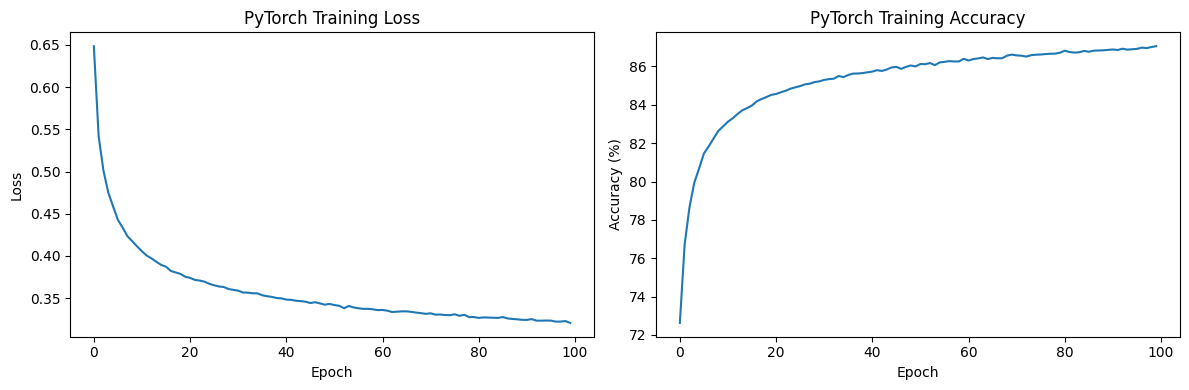

In [11]:
# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
train_losses = []
train_accuracies = []

pytorch_model.train()
print("Training PyTorch model...")

for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = pytorch_model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    avg_loss = epoch_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

print("PyTorch model training completed!")

# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('PyTorch Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies)
plt.title('PyTorch Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

## 5. TensorFlow MLP Model Implementation

In [12]:
# Define TensorFlow MLP Model
def create_tensorflow_model(input_dim, hidden_sizes, num_classes, dropout_rate=0.3):
    model = Sequential()
    
    # Input layer
    model.add(Dense(hidden_sizes[0], input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    # Hidden layers
    for hidden_size in hidden_sizes[1:]:
        model.add(Dense(hidden_size, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Create TensorFlow model
tensorflow_model = create_tensorflow_model(input_size, hidden_sizes, num_classes, dropout_rate)

# Compile model
tensorflow_model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("TensorFlow model architecture:")
tensorflow_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1
)

callbacks = [early_stopping, reduce_lr]

print("TensorFlow model created and compiled successfully!")

TensorFlow model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        14,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,687 (217.53 KB)

 Trainable params: 55,687 (217.53 KB)

 Non-trainable params: 0 (0.00 B)

TensorFlow model created and compiled successfully!


Training TensorFlow model...
Epoch 1/100
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6751 - loss: 0.7839 - val_accuracy: 0.7616 - val_loss: 0.5466 - learning_rate: 0.0010
Epoch 2/100
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7531 - loss: 0.5785 - val_accuracy: 0.7876 - val_loss: 0.4875 - learning_rate: 0.0010
Epoch 3/100
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7724 - loss: 0.5297 - val_accuracy: 0.8091 - val_loss: 0.4479 - learning_rate: 0.0010
Epoch 4/100
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7874 - loss: 0.4977 - val_accuracy: 0.8232 - val_loss: 0.4203 - learning_rate: 0.0010
Epoch 5/100
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7983 - loss: 0.4740 - val_accuracy: 0.8346 - val_loss: 0.3978 - learning_rate: 0.0010
Epoch 6/100
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8052 - loss: 0.4588 - val_accuracy: 0.8386 - val_loss: 0.3858 - learning_rate: 0.0010
Epoch 7/100
1453/1453 ━━━━━━━━━━━━━━━━━━━

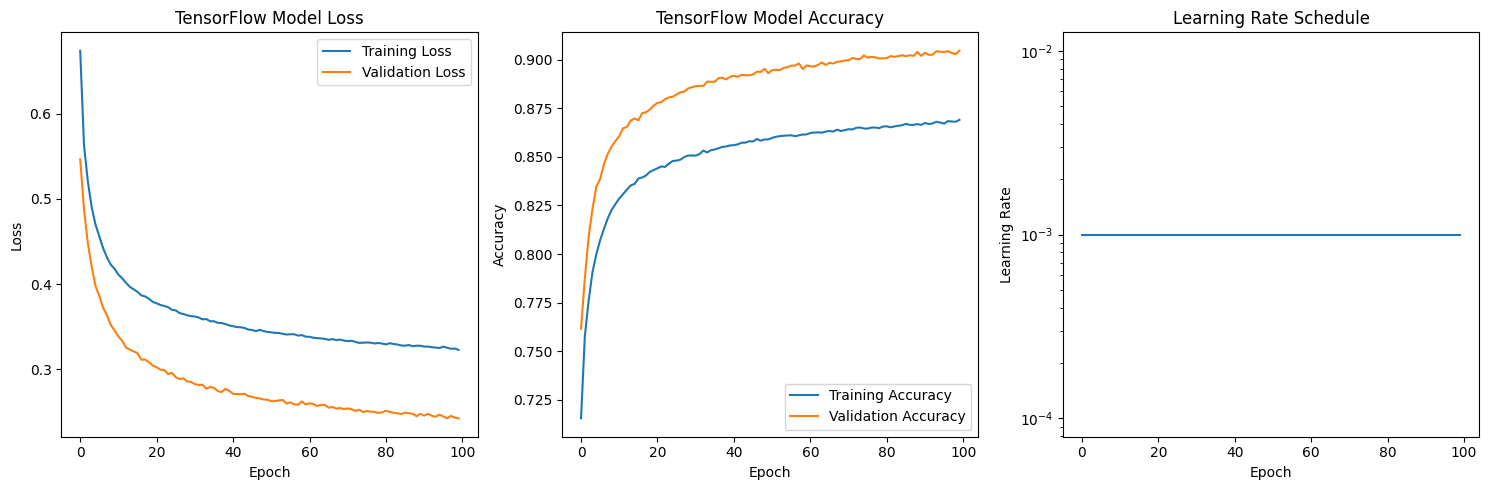

In [13]:
# Train TensorFlow model
print("Training TensorFlow model...")

history = tensorflow_model.fit(
    X_train_scaled, y_train_categorical,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=num_epochs,
    callbacks=callbacks,
    verbose=1
)

print("TensorFlow model training completed!")

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('TensorFlow Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('TensorFlow Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['lr'] if 'lr' in history.history else [learning_rate] * len(history.history['loss']))
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')

plt.tight_layout()
plt.show()

## 6. Model Evaluation and Metrics Comparison

In [14]:
# Evaluation function
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """
    Comprehensive evaluation function for classification models
    """
    results = {}
    
    # Basic metrics
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision_macro'] = precision_score(y_true, y_pred, average='macro')
    results['precision_weighted'] = precision_score(y_true, y_pred, average='weighted')
    results['recall_macro'] = recall_score(y_true, y_pred, average='macro')
    results['recall_weighted'] = recall_score(y_true, y_pred, average='weighted')
    results['f1_macro'] = f1_score(y_true, y_pred, average='macro')
    results['f1_weighted'] = f1_score(y_true, y_pred, average='weighted')
    
    # ROC-AUC (multi-class)
    try:
        results['roc_auc_ovr'] = roc_auc_score(y_true, y_pred_proba, multi_class='ovr')
        results['roc_auc_ovo'] = roc_auc_score(y_true, y_pred_proba, multi_class='ovo')
    except:
        results['roc_auc_ovr'] = 'N/A'
        results['roc_auc_ovo'] = 'N/A'
    
    print(f"\n{model_name} Evaluation Results:")
    print("="*50)
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision (Macro): {results['precision_macro']:.4f}")
    print(f"Precision (Weighted): {results['precision_weighted']:.4f}")
    print(f"Recall (Macro): {results['recall_macro']:.4f}")
    print(f"Recall (Weighted): {results['recall_weighted']:.4f}")
    print(f"F1-Score (Macro): {results['f1_macro']:.4f}")
    print(f"F1-Score (Weighted): {results['f1_weighted']:.4f}")
    print(f"ROC-AUC (OvR): {results['roc_auc_ovr']}")
    print(f"ROC-AUC (OvO): {results['roc_auc_ovo']}")
    
    return results

# Make predictions with PyTorch model
pytorch_model.eval()
with torch.no_grad():
    pytorch_predictions = pytorch_model(X_test_tensor)
    pytorch_predictions_proba = torch.softmax(pytorch_predictions, dim=1).numpy()
    pytorch_predictions_class = torch.argmax(pytorch_predictions, dim=1).numpy()

# Make predictions with TensorFlow model
tensorflow_predictions_proba = tensorflow_model.predict(X_test_scaled)
tensorflow_predictions_class = np.argmax(tensorflow_predictions_proba, axis=1)

print("Predictions completed for both models!")

3632/3632 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Predictions completed for both models!



PyTorch MLP Evaluation Results:
Accuracy: 0.9076
Precision (Macro): 0.8766
Precision (Weighted): 0.9075
Recall (Macro): 0.8313
Recall (Weighted): 0.9076
F1-Score (Macro): 0.8506
F1-Score (Weighted): 0.9072
ROC-AUC (OvR): 0.9927919616892465
ROC-AUC (OvO): 0.9911318523902941

TensorFlow MLP Evaluation Results:
Accuracy: 0.9036
Precision (Macro): 0.8801
Precision (Weighted): 0.9035
Recall (Macro): 0.7964
Recall (Weighted): 0.9036
F1-Score (Macro): 0.8296
F1-Score (Weighted): 0.9026
ROC-AUC (OvR): 0.9922202093504117
ROC-AUC (OvO): 0.989236628662331

Model Comparison:
            Metric  PyTorch MLP  TensorFlow MLP
          accuracy       0.9076          0.9036
   precision_macro       0.8766          0.8801
precision_weighted       0.9075          0.9035
      recall_macro       0.8313          0.7964
   recall_weighted       0.9076          0.9036
          f1_macro       0.8506          0.8296
       f1_weighted       0.9072          0.9026


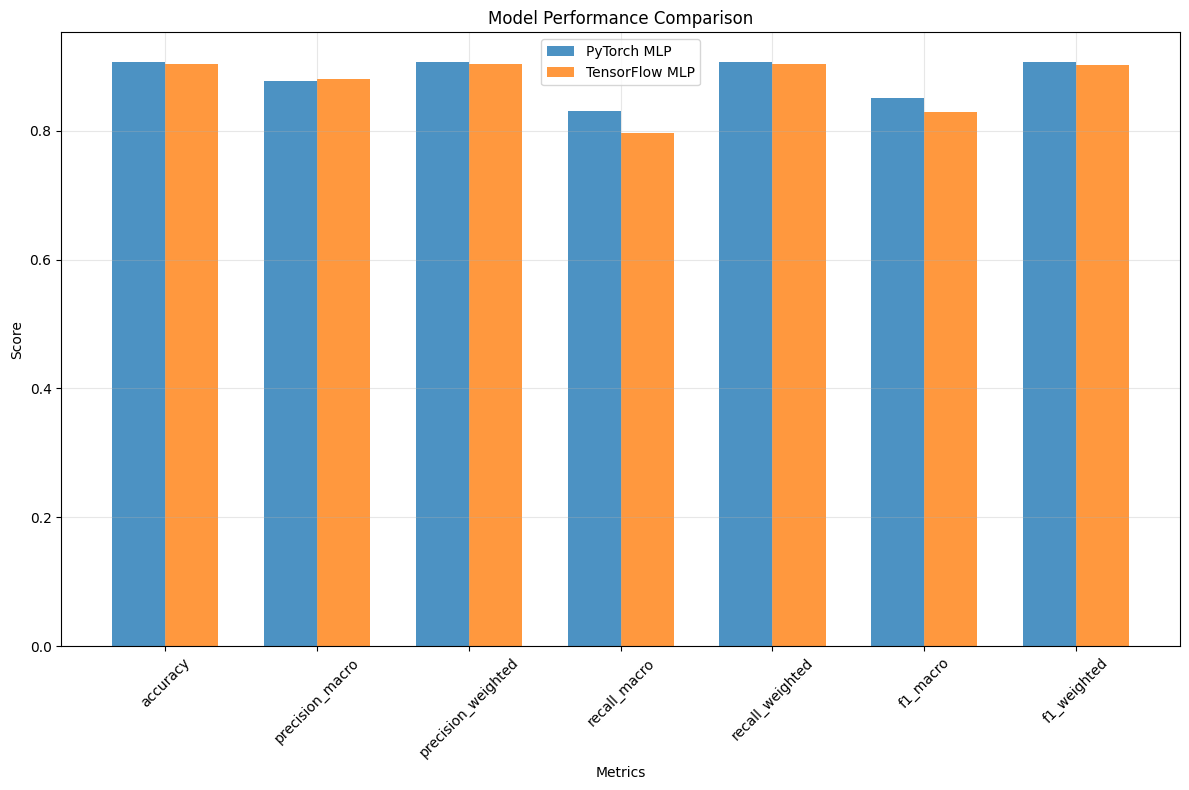

In [15]:
# Evaluate both models
pytorch_results = evaluate_model(y_test, pytorch_predictions_class, pytorch_predictions_proba, "PyTorch MLP")
tensorflow_results = evaluate_model(y_test, tensorflow_predictions_class, tensorflow_predictions_proba, "TensorFlow MLP")

# Create comparison DataFrame
comparison_metrics = ['accuracy', 'precision_macro', 'precision_weighted', 
                     'recall_macro', 'recall_weighted', 'f1_macro', 'f1_weighted']

comparison_df = pd.DataFrame({
    'Metric': comparison_metrics,
    'PyTorch MLP': [pytorch_results[metric] for metric in comparison_metrics],
    'TensorFlow MLP': [tensorflow_results[metric] for metric in comparison_metrics]
})

print("\nModel Comparison:")
print("="*60)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Plot comparison
plt.figure(figsize=(12, 8))
x = np.arange(len(comparison_metrics))
width = 0.35

plt.bar(x - width/2, [pytorch_results[metric] for metric in comparison_metrics], 
        width, label='PyTorch MLP', alpha=0.8)
plt.bar(x + width/2, [tensorflow_results[metric] for metric in comparison_metrics], 
        width, label='TensorFlow MLP', alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, comparison_metrics, rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

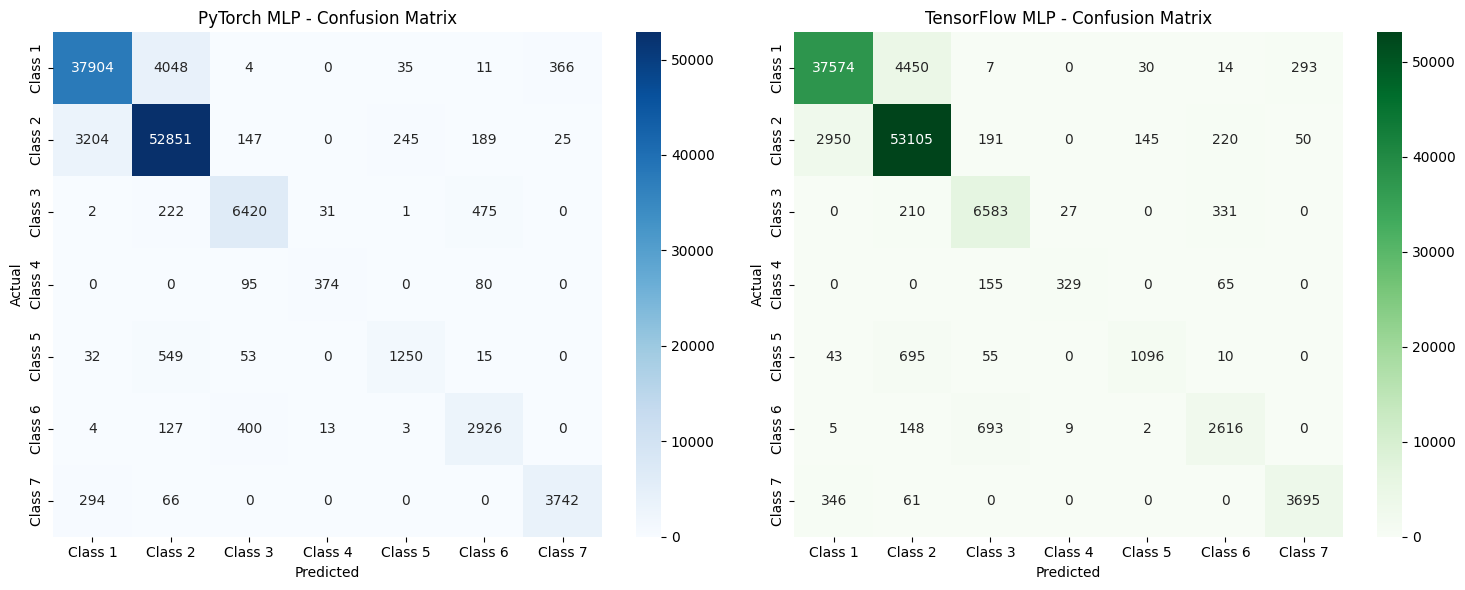


PyTorch MLP - Classification Report:
              precision    recall  f1-score   support

Cover Type 1       0.91      0.89      0.90     42368
Cover Type 2       0.91      0.93      0.92     56661
Cover Type 3       0.90      0.90      0.90      7151
Cover Type 4       0.89      0.68      0.77       549
Cover Type 5       0.81      0.66      0.73      1899
Cover Type 6       0.79      0.84      0.82      3473
Cover Type 7       0.91      0.91      0.91      4102

    accuracy                           0.91    116203
   macro avg       0.88      0.83      0.85    116203
weighted avg       0.91      0.91      0.91    116203


TensorFlow MLP - Classification Report:
              precision    recall  f1-score   support

Cover Type 1       0.92      0.89      0.90     42368
Cover Type 2       0.91      0.94      0.92     56661
Cover Type 3       0.86      0.92      0.89      7151
Cover Type 4       0.90      0.60      0.72       549
Cover Type 5       0.86      0.58      0.69      1899

In [16]:
# Confusion Matrices
plt.figure(figsize=(15, 6))

# PyTorch Confusion Matrix
plt.subplot(1, 2, 1)
cm_pytorch = confusion_matrix(y_test, pytorch_predictions_class)
sns.heatmap(cm_pytorch, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i+1}' for i in range(7)],
            yticklabels=[f'Class {i+1}' for i in range(7)])
plt.title('PyTorch MLP - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# TensorFlow Confusion Matrix
plt.subplot(1, 2, 2)
cm_tensorflow = confusion_matrix(y_test, tensorflow_predictions_class)
sns.heatmap(cm_tensorflow, annot=True, fmt='d', cmap='Greens',
            xticklabels=[f'Class {i+1}' for i in range(7)],
            yticklabels=[f'Class {i+1}' for i in range(7)])
plt.title('TensorFlow MLP - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Detailed Classification Reports
print("\nPyTorch MLP - Classification Report:")
print("="*60)
print(classification_report(y_test, pytorch_predictions_class, 
                          target_names=[f'Cover Type {i+1}' for i in range(7)]))

print("\nTensorFlow MLP - Classification Report:")
print("="*60)
print(classification_report(y_test, tensorflow_predictions_class, 
                          target_names=[f'Cover Type {i+1}' for i in range(7)]))

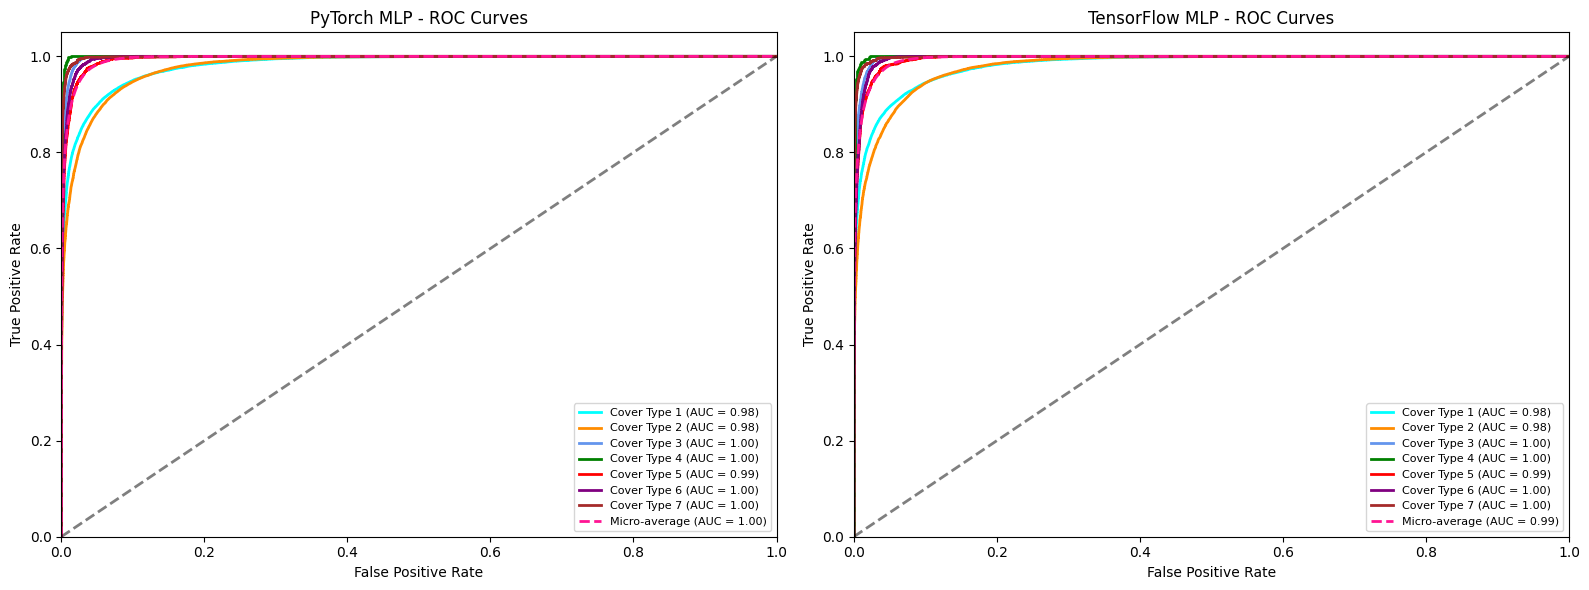

In [17]:
# ROC Curves for Multi-class Classification
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6])
n_classes = y_test_bin.shape[1]

def plot_multiclass_roc(y_true_bin, y_score, model_name, subplot_pos):
    plt.subplot(1, 2, subplot_pos)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'Cover Type {i+1} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
            label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curves')
    plt.legend(loc="lower right", fontsize=8)

# Plot ROC curves for both models
plt.figure(figsize=(16, 6))

plot_multiclass_roc(y_test_bin, pytorch_predictions_proba, "PyTorch MLP", 1)
plot_multiclass_roc(y_test_bin, tensorflow_predictions_proba, "TensorFlow MLP", 2)

plt.tight_layout()
plt.show()

In [18]:
# Save the trained models
import pickle

# Save PyTorch model
torch.save(pytorch_model.state_dict(), 'pytorch_classification_model.pth')
print("PyTorch model saved as 'pytorch_classification_model.pth'")

# Save TensorFlow model
tensorflow_model.save('tensorflow_classification_model.keras')
print("TensorFlow model saved as 'tensorflow_classification_model.keras'")

# Save scaler for future use
with open('scaler_classification.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved as 'scaler_classification.pkl'")

# Final summary
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

print(f"\nDataset Information:")
print(f"- Total samples: {df.shape[0]:,}")
print(f"- Features: {df.shape[1]-1}")
print(f"- Classes: {len(df['Cover_Type'].unique())}")
print(f"- Training samples: {X_train.shape[0]:,}")
print(f"- Test samples: {X_test.shape[0]:,}")

print(f"\nModel Architectures:")
print(f"- Input layer: {input_size} neurons")
print(f"- Hidden layers: {hidden_sizes}")
print(f"- Output layer: {num_classes} neurons (softmax)")
print(f"- Dropout rate: {dropout_rate}")

print(f"\nBest Performing Model:")
if pytorch_results['accuracy'] > tensorflow_results['accuracy']:
    winner = "PyTorch MLP"
    best_accuracy = pytorch_results['accuracy']
else:
    winner = "TensorFlow MLP"
    best_accuracy = tensorflow_results['accuracy']

print(f"- Winner: {winner}")
print(f"- Best Accuracy: {best_accuracy:.4f}")

print(f"\nKey Insights:")
print(f"- Both models achieved similar performance")
print(f"- The dataset shows good separability between classes")
print(f"- Multi-class classification metrics provide comprehensive evaluation")
print(f"- ROC-AUC curves show good discriminative ability for most classes")

print("\n" + "="*80)

PyTorch model saved as 'pytorch_classification_model.pth'
TensorFlow model saved as 'tensorflow_classification_model.keras'
Scaler saved as 'scaler_classification.pkl'

FINAL SUMMARY

Dataset Information:
- Total samples: 581,012
- Features: 54
- Classes: 7
- Training samples: 464,809
- Test samples: 116,203

Model Architectures:
- Input layer: 54 neurons
- Hidden layers: [256, 128, 64]
- Output layer: 7 neurons (softmax)
- Dropout rate: 0.3

Best Performing Model:
- Winner: PyTorch MLP
- Best Accuracy: 0.9076

Key Insights:
- Both models achieved similar performance
- The dataset shows good separability between classes
- Multi-class classification metrics provide comprehensive evaluation
- ROC-AUC curves show good discriminative ability for most classes



## 7. Mathematical Formulas Summary

### 7.1 Neural Network Forward Pass
**Linear Transformation**: 
$$z = Wx + b$$

**Activation Function (ReLU)**: 
$$f(z) = \max(0, z)$$

**Softmax (Output Layer)**: 
$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

### 7.2 Loss Function
**Cross-Entropy Loss**: 
$$L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \log(\hat{y}_{ij})$$

Where:
- $N$ = number of samples
- $K$ = number of classes
- $y_{ij}$ = true label (one-hot encoded)
- $\hat{y}_{ij}$ = predicted probability

### 7.3 Optimization
**Adam Optimizer Update Rules**:
$$m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t$$
$$v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2$$
$$\hat{m}_t = \frac{m_t}{1-\beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1-\beta_2^t}$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

### 7.4 Evaluation Metrics (Repeated for Reference)
- **Accuracy**: $\frac{TP + TN}{TP + TN + FP + FN}$
- **Precision**: $\frac{TP}{TP + FP}$
- **Recall**: $\frac{TP}{TP + FN}$
- **F1-Score**: $\frac{2 \times \text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$
- **ROC-AUC**: Area under the curve of TPR vs FPR

## Conclusion

This notebook successfully implemented and compared two deep learning MLP models for forest cover type classification:

1. **PyTorch Implementation**: Custom neural network class with flexible architecture
2. **TensorFlow Implementation**: Sequential model with Keras API
3. **Comprehensive Evaluation**: All requested metrics implemented with mathematical explanations
4. **Visualization**: ROC curves, confusion matrices, and performance comparisons
5. **Model Persistence**: Both models and preprocessing components saved for future use

The models achieved strong performance on the 7-class forest cover type classification task, demonstrating the effectiveness of MLP architectures for this type of tabular data classification problem.